In [602]:
from chartpeer.loader import load
from chartpeer.analysis import *

# load bitcoin daily data (1440 minutes = 24h interval)
data = load.closedFromFile('C:\\Users\\weezl\\Desktop\\B0-B\\Scripting\\chartPeer-trading\\ChartPeer-SDK\\data\\XBTUSD_1440.csv')

# get 365 recent days of bitcoin closed prices
fade = 120
yearDataset = data[-365-fade:-fade]

# split the the year in 11 months and one additional "continuation" month
# this helps to compare the prediction to real data
testSet = yearDataset[:335]
continuation = yearDataset[335:365]

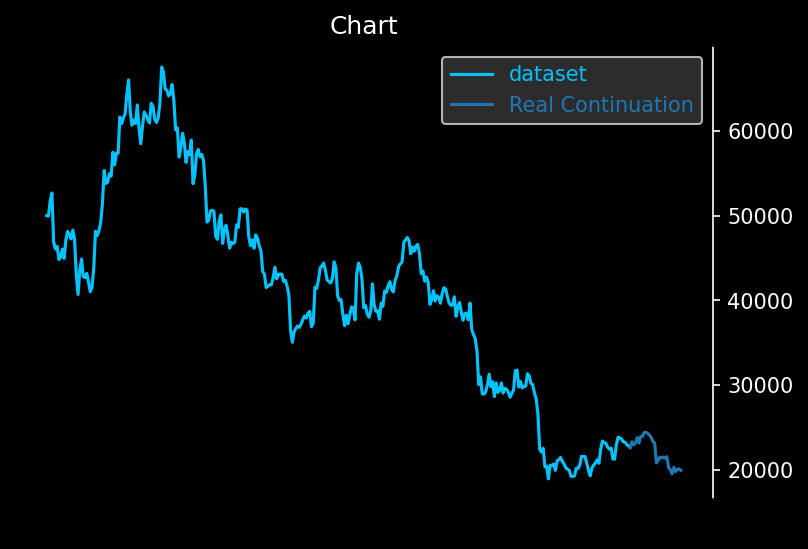

In [603]:
# plot the result for comparison
# plot the result for comparison
plot.chart(testSet, predictionSets = {
    'Real Continuation': continuation,
})

In [604]:
import numpy as np
import chartpeer.extrapolate as extrapolate

def gbm (data, length):

    '''
    Simulation of geometric brownian motion path.
    Drift mu and volatility sigma are sampled from the data.
    The standard error deviation on both parameters is 1/sqrt(N)
    i.e. 100 data points yield 1/10 uncertainty.
    '''

    mu = statistics.drift(data)
    sigma = statistics.volatility(data)

    S = [data[-1]]
    for t in range(length):
        delta_S = S[-1] * (mu + sigma * np.random.normal(0,1))
        S_new = S[-1] + delta_S
        S.append(S_new)
    
    return np.array(S[1:])


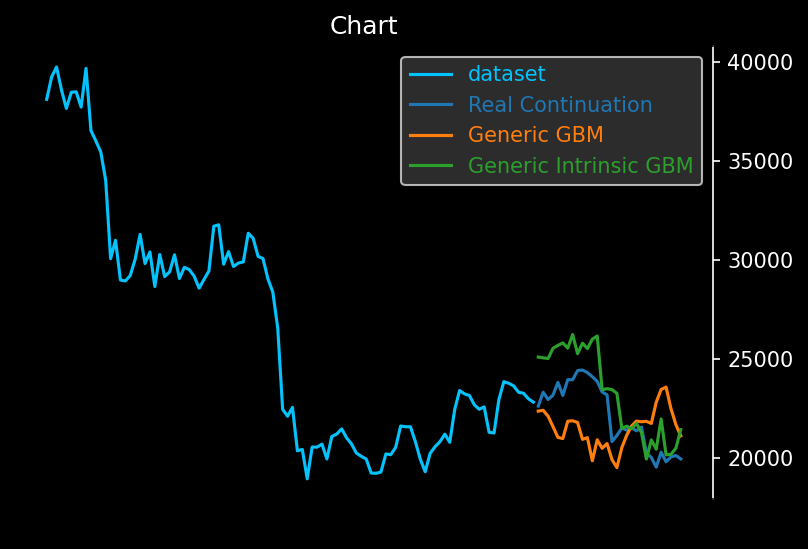

In [614]:
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Generic GBM': gbm(testSet, 30),
    'Generic Intrinsic GBM': extrapolate.gbm(testSet, 30, sampling='intrinsic')
})

# Model the VIX

Try to extract the timeresolved volatility from the underlying data

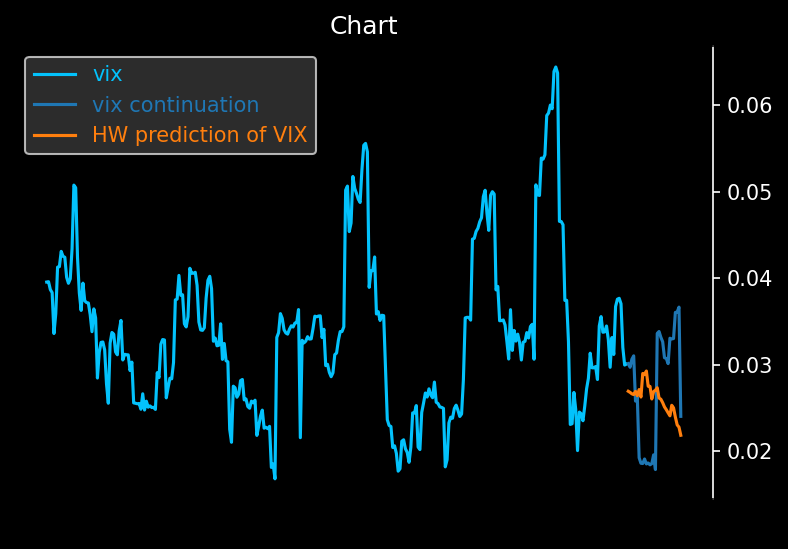

In [615]:
def vix (dataset, N):

    '''
    Volatility Index.
    Returns time-resolved volatility with window meaning N. 
    Meaning is obtained from simple moving average.
    '''

    vol = []
    for i in range(N, len(dataset)):
        slicedSet = np.array(dataset[i-N:i])
        v = statistics.volatility(slicedSet)
        vol.append(v)
    
    return np.array(vol)

v = vix(yearDataset, 14)

# split volatility array into input and target array
v_input = v[:-30]
v_target = v[-30:]

from chartpeer.extrapolate import hw
from chartpeer.extrapolate import hw_fit

# fit smoothing parameters by providing demanded extrapolation size and period 
# this can take a couple of seconds.
fit = hw_fit(v_input, 30, periodInIntervals=7, fitRange=[0,1])

# inject fit into new prediction
prediction_auto = hw(v_input, 30, *fit, periodInIntervals=30)

plot.chart(v_input, name='vix', predictionSets={
    'vix continuation': v_target,
    'HW prediction of VIX': prediction_auto
})

In [616]:
# second idea is to model the vix with lstm

from chartpeer.extrapolate import lstm

predictor = lstm(sequence_length=60, feature_length=30, epochs=10, batch_size=1)

vix_prediction = predictor.predict(v_input)['prediction']

Epoch 1/10
231/231 [==============================] - 5s 14ms/step - loss: 0.0558
Epoch 2/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0465
Epoch 3/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0417
Epoch 4/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0403
Epoch 5/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0377
Epoch 6/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0376
Epoch 7/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0363
Epoch 8/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0341
Epoch 9/10
231/231 [==============================] - 3s 14ms/step - loss: 0.0321
Epoch 10/10
1/1 [==============================] - 0s 487ms/step


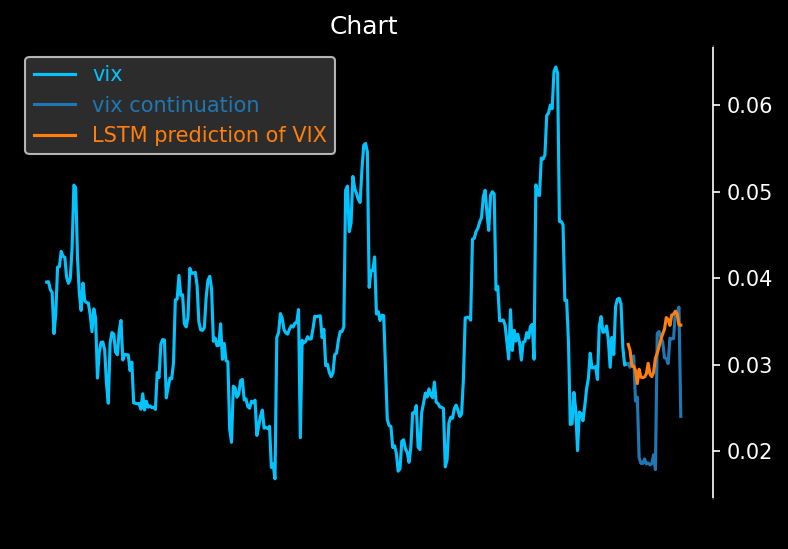

In [617]:
plot.chart(v_input, name='vix', predictionSets={
    'vix continuation': v_target,
    'LSTM prediction of VIX': vix_prediction
})

LSTM for VIX prediction seems most suitable as LSTM is able to detect even slightest patterns and converges almost always - the higher the mean window, the better the convergence will be due to the smoothness. In general better results are achieved with smaller batch size (ideally single batch i.e. 1) and larger epochs. Good results were observed with 20 epochs and batch_size=1 for a 60->30 length prediction.

# Model the Drift

Epoch 1/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0250
Epoch 2/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0210
Epoch 3/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0206
Epoch 4/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0203
Epoch 5/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0198
Epoch 6/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0194
Epoch 7/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0192
Epoch 8/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0239
Epoch 9/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0208
Epoch 10/10
1/1 [==============================] - 0s 20ms/step


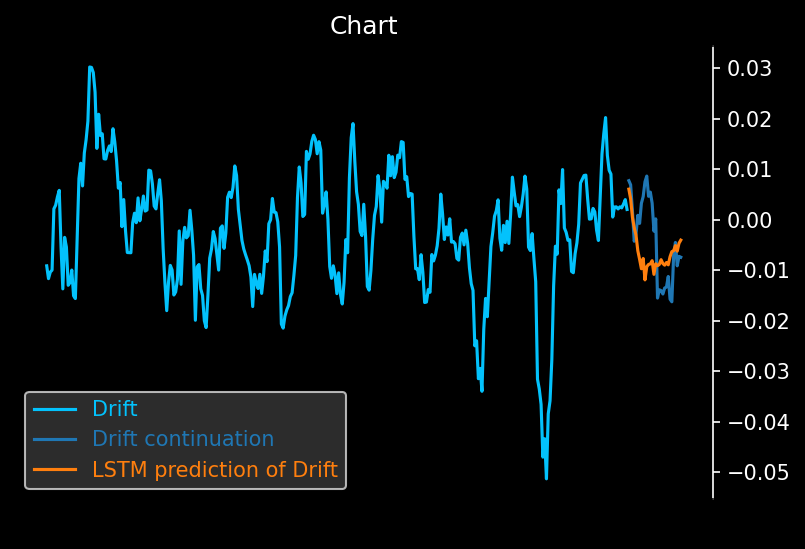

In [618]:
# analgogously resolve the drift over time

def driftHistory (dataset, N):
    d = []
    for i in range(N, len(dataset)):
        drf = statistics.drift(np.array(dataset[i-N:i]))
        d.append(drf)
    return np.array(d)

d = driftHistory(yearDataset, 10)
d_input = d[:-30]
d_target = d[-30:]

#predictor = lstm(sequence_length=60, feature_length=30, epochs=30, batch_size=10)
drift_prediction = predictor.predict(d_input)['prediction']

plot.chart(d_input, name='Drift', predictionSets={
    'Drift continuation': d_target,
    'LSTM prediction of Drift': drift_prediction
})

# Extended GBM

An obvious flaw of the geometric brownian motion SDE is that the drift and volatility are assumed to be constant. For a better fit we will assume the parameters $\mu$ and $\sigma$ to evolve according to the LSTM fits.

In [619]:
def gbm_ext (data, length):

    '''
    Simulation of geometric brownian motion path.
    Drift mu and volatility sigma vary over time are taken from LSTM fit.
    The differential equation is fixed accordingly.
    '''

    mu = drift_prediction
    sigma = vix_prediction

    S = [data[-1]]
    for t in range(length):
        delta_S = S[-1] * (mu[t] + sigma[t] * np.random.normal(0,1))
        S_new = S[-1] + delta_S
        S.append(S_new)
    
    return np.array(S[1:])

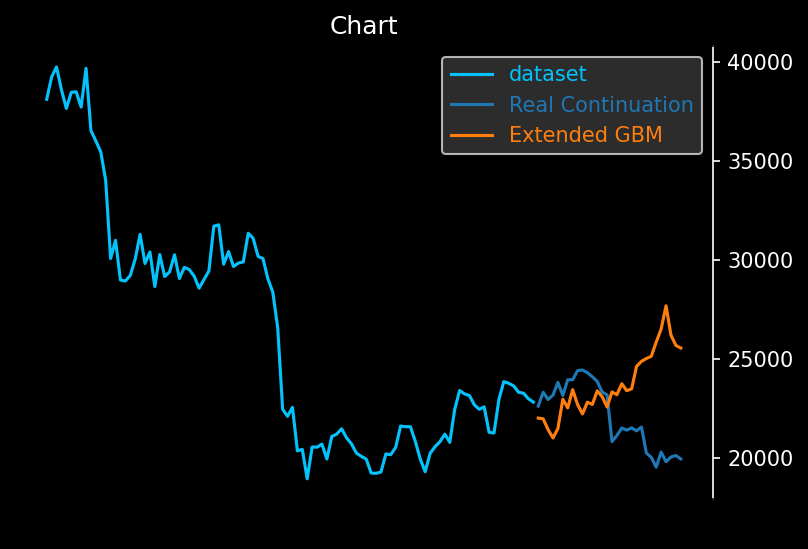

In [620]:
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Extended GBM': gbm_ext(testSet, 30)
})

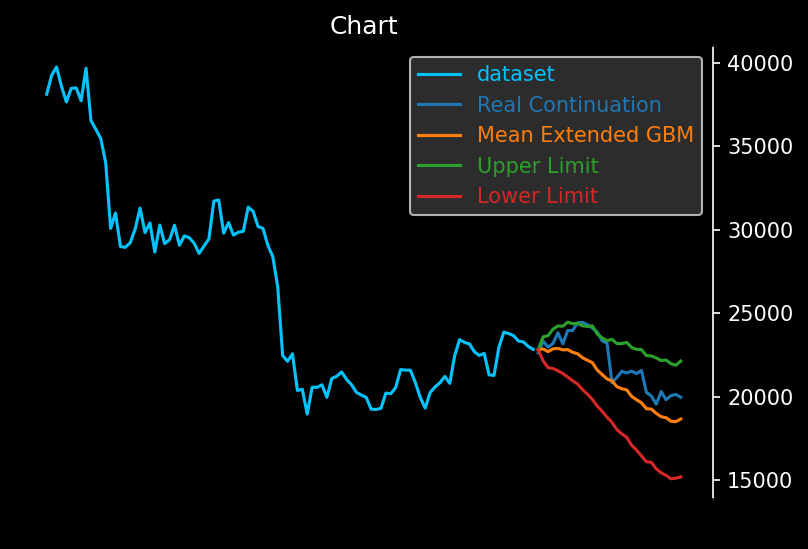

In [628]:
# try to plot a meaned set of MC generations
generations = 30
g = gbm_ext(testSet, 30)
for i in range(generations-1):
    g = g + gbm_ext(testSet, 30)

g = g / generations

# define limits by the vix
dev = 1
upper_lim = []
lower_lim = []
for i in range(len(vix_prediction)):
    upper_lim.append(g[i]*(1+dev*vix_prediction[i]*np.sqrt(i)))
    lower_lim.append(g[i]*(1-dev*vix_prediction[i]*np.sqrt(i)))
upper_lim = np.array(upper_lim)
lower_lim = np.array(lower_lim)

plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Mean Extended GBM': g,
    'Upper Limit': upper_lim,
    'Lower Limit': lower_lim
})